# Global drought map

This script is using a sample from the ERA5--Drought data set from the European Centre for Medium-range Weather Forecasts (ECMWF) and plots a global map of the dataset. 
The output of this notebook is published as Figure 1 in 
> Keune, J., F. Di Giuseppe, C. Barnard, and F. Wetterhall (XXXX): \textbf{ERA5--Drought: Global drought indicators based on ECMWF reanalysis}, submitted to Scientific Data. 

## Setup & Settings

#### Load libraries

In [96]:
import os 
import sys
import netCDF4 as nc4
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

#### Plot settings

In [97]:
mylevels     = [-10000,-1000,-2,-1.5,-1,1,1.5,2,1000]
mycollisthex = ['#bebebe','#663300','#8c6640','#b29980','#ffffff','#99b280','#668c40','#336600']
legnames     = ["masked","extremely dry", "severely dry", "moderately dry", "near normal", "moderately wet", "severely wet", "extremely wet"]

#### Some helpful functions

In [98]:
def hex2rgb(hexs):
   return tuple(int(hexs[i:i+2], 16)/255 for i in (0, 2, 4))

#### Function to plot global map

In [99]:
def worldmap_drought(data_2d, 
                     collist_hex, 
                     levels,
                     legnames,
                     figname="figures/SPEI12_global_19000000.png",
                     latlines=[-30,30], plot_latlines=False, mytitle=""):

    plt.figure(figsize=(9, 4));
    #plt.box(False)
    ax = plt.axes(projection=ccrs.Robinson(), frameon=False);
    ax.coastlines(color='black', lw=0.25)
    data_2d.plot(ax=ax, transform=ccrs.PlateCarree(),
                              x='lon', y='lat',
                              add_colorbar=False,
                              colors=collist_hex,
                              levels=levels,
                              vmin=-3, vmax=3)
    ax.set_title(mytitle)

    # horizontal lat-lines
    if plot_latlines:
        geodetic = ccrs.Geodetic()
        robinson = ccrs.Robinson()
        for ilat in latlines:
            ilon_1, ilat_1 = robinson.transform_point(-179, ilat, geodetic)
            ilon_2, ilat_2 = robinson.transform_point(+179, ilat, geodetic)
            ax.plot([ilon_1, ilon_2], [ilat_1, ilat_2], color='grey', linewidth=0.5, transform=robinson, linestyle=':')

    ax.set_extent([-170000, 180, -50, 82]) # (x0, x1, y0, y1)
    
    legend_elements = []
    for i in range(len(legnames)):
        legend_elements.append(Line2D([0], [0], marker='s', color='w', label=legnames[i], markerfacecolor=hex2rgb(collist_hex[i][1:]), markersize=8))
    plt.legend(handles=legend_elements, fontsize="8", loc ="lower left", ncol=1)

    plt.tight_layout()
    #plt.subplots_adjust(bottom=0.025, hspace=0.5, wspace=0.05)
    plt.savefig(figname, format=None, metadata=None,
                bbox_inches=None, pad_inches=0.1, dpi=300,
                facecolor='auto', edgecolor='auto',
                backend=None)
    plt.show()

## Drought indicator

### Settings

In [100]:
ref_syyyy = 1991
ref_eyyyy = 2020
indicator = "SPEI"
window    = 12
yyyy      = 2023
mm        = 12
dataset   = "era5"
stream    = "moda"
distribut = "genlogistic"
ipath     = "/ec/vol/centaur/nejk/drought_monitor"
ifile_name= f"{indicator}{window}_{distribut}_global_{dataset}_{stream}_ref{ref_syyyy}to{ref_eyyyy}_{yyyy}{str(mm).zfill(2)}.nc"
ifile     = f"{ipath}/{indicator.lower()}/{indicator.lower()}{window}/{ifile_name}"

### Read drought indicator

In [101]:
drought_2d = xr.open_dataset(ifile)
print(drought_2d)

<xarray.Dataset> Size: 8MB
Dimensions:  (time: 1, lat: 721, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 8B 2023-12-01T06:00:00
  * lat      (lat) float64 6kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float64 12kB -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
Data variables:
    SPEI12   (time, lat, lon) float64 8MB ...
Attributes:
    title:        SPEI12
    description:  Drought Index: Standardized Drought Index calculated accord...
    history:      Created 03/04/2024 16:52:57 using DRYFALL.
    institution:  ECMWF
    source:       DRYFALL v0.1


### Apply masks

#### Mask NaNs

In [102]:
drought_2d_masked = xr.where(drought_2d[f'{indicator}{window}'] == -9999, np.nan, drought_2d[f'{indicator}{window}'])
#print(drought_2d_masked)

#### Mask deserts and polar regions

Here, we use the global Koeppen-Geiger maps developed by Beck et al. (2023) to mask barren lands. 

>   Beck, H. E., T. R. McVicar, N. Vergopolan, A. Berg, N. J. Lutsko, A. Dufour,
>   Z. Zeng, X. Jiang, A. I. J. M. van Dijk, and D. G. Miralles. High-resolution
>   (1 km) Köppen-Geiger maps for 1901-2099 based on constrained CMIP6
>   projections, Scientific Data 10, 724 (2023).

Data downloaded from https://figshare.com/articles/dataset/High-resolution_1_km_K_ppen-Geiger_maps_for_1901_2099_based_on_constrained_CMIP6_projections/21789074/1 and regridded to 0.25deg.

The categorization for the data is as follows:

| Number   |      Abbreviation      |  Description |
|----------|:----------------------:|-------------:|
|    1:  | Af   | Tropical, rainforest
|    2:  | Am   | Tropical, monsoon
|    3:  | Aw   | Tropical, savannah
|    4:  | BWh  | Arid, desert, hot
|    5:  | BWk  | Arid, desert, cold
|    6:  | BSh  | Arid, steppe, hot
|    7:  | BSk  | Arid, steppe, cold
|    8:  | Csa  | Temperate, dry summer, hot summer
|    9:  | Csb  | Temperate, dry summer, warm summer
|    10: | Csc  | Temperate, dry summer, cold summer
|    11: | Cwa  | Temperate, dry winter, hot summer 
|    12: | Cwb  | Temperate, dry winter, warm summer
|    13: | Cwc  | Temperate, dry winter, cold summer
|    14: | Cfa  | Temperate, no dry season, hot summer
|    15: | Cfb  | Temperate, no dry season, warm summer
|    16: | Cfc  | Temperate, no dry season, cold summer
|    17: | Dsa  | Cold, dry summer, hot summer
|    18: | Dsb  | Cold, dry summer, warm summer
|    19: | Dsc  | Cold, dry summer, cold summer
|    20: | Dsd  | Cold, dry summer, very cold winter
|    21: | Dwa  | Cold, dry winter, hot summer
|    22: | Dwb  | Cold, dry winter, warm summer
|    23: | Dwc  | Cold, dry winter, cold summer
|    24: | Dwd  | Cold, dry winter, very cold winter
|    25: | Dfa  | Cold, no dry season, hot summer
|    26: | Dfb  | Cold, no dry season, warm summer
|    27: | Dfc  | Cold, no dry season, cold summer
|    28: | Dfd  | Cold, no dry season, very cold winter
|    29: | ET   | Polar, tundra
|    30: | EF   | Polar, frost


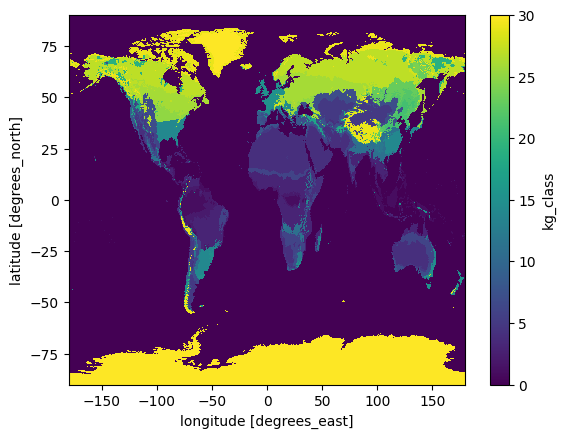

In [103]:
vfile = "/ec/vol/centaur/nejk/veg_data/Beck_KG_highres/1991_2020/koppen_geiger_remap_0p25.nc"
kg_data = xr.open_dataset(vfile)
#print(kg_data)
kg_data['kg_class'].plot()

In [104]:
kg_mask           = xr.where( (kg_data['kg_class'] == 4) | (kg_data['kg_class'] == 5) | (kg_data['kg_class'] == 30) , 1, 0)
kg_mask           = xr.where( (kg_data['kg_class'] == 4) | (kg_data['kg_class'] == 5) | (kg_data['kg_class'] == 30) , 1, 0)
#kg_mask.plot()

In [105]:
# Wet set everything that is 'masked' to -9999
#drought_2d_masked = xr.where( (kg_mask == 1) & (~np.isnan(drought_2d_masked)) , -9999, drought_2d_masked)
#drought_2d_masked.plot(vmax=3, vmin=-3)

#### Mask barren areas

In [106]:
vfile = "/home/nejk/code/dryfall_oper/helpers_oper/barren_mask.nc"
bmask = xr.open_dataset(vfile)
#bmask['barren_mask'].plot()

In [107]:
drought_2d_masked = xr.where( (bmask['barren_mask'][0,:,:] == 1) & (~np.isnan(drought_2d_masked)) , -9999, drought_2d_masked)


## Plot global map

In [108]:
print(f"Figure1_{indicator}{window}_{yyyy}{str(mm).zfill(2)}.pdf")

Figure1_SPEI12_202312.pdf


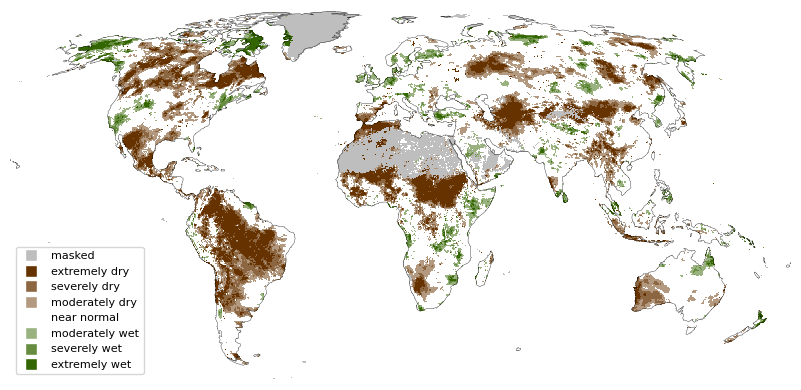

In [109]:
worldmap_drought(drought_2d_masked, 
                 collist_hex = mycollisthex, 
                 #levels = [-10000].append(mylevels),
                 #legnames = ["masked"].append(legnames),
                 levels = [-10000,-1000,-2,-1.5,-1,1,1.5,2,1000],
                 legnames = ["masked","extremely dry", "severely dry", "moderately dry", "near normal", "moderately wet", "severely wet", "extremely wet"],
                 figname = f"Figure1_{indicator}{window}_{yyyy}{str(mm).zfill(2)}.pdf",
                 latlines = [-30,30], 
                 plot_latlines =False, 
                 mytitle       = "")